<a href="https://colab.research.google.com/github/VeStudent/recyclenet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### """adapted""" from [classification.ipynb](https://www.tensorflow.org/tutorials/images/classification)
####Dataset from [kaggle](https://www.kaggle.com/mostafaabla/garbage-classification)

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

If you already have the model weights, you can import it here and skip to [predictions on new data](https://colab.research.google.com/drive/1l02Zrc0Yf5BdJBYoYeFTrupkCNDubrrP#scrollTo=dtv5VbaVb-3W).

In [ ]:
batch_size = 10
img_height = 100
img_width = 100
class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
num_classes = len(class_names)
model = Sequential([
  keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from google.colab import files
model.load_weights(next(iter(files.upload())))

Saving model.h5 to model (1).h5


## Get the data
save the dataset as garbo.zip to the main folder of your Google Drive ...

The actual dataset looks like this  
<sub>this is what it should look like *inside* `garbo.zip`</sub>

```
garbage_classification/
  battery/
  biological/
  brown-glass/
  cardboard/
  clothes/
  green-glass/
  metal/
  paper/
  plastic/
  shoes/
  trash/
  white-glass/
```

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -d /content /content/gdrive/MyDrive/garbo.zip
data_dir = pathlib.Path('/content/garbage_classification')
#uncomment following lines if you're using your own dataset.
##!unzip /content/dataset-resized.zip
##data_dir = pathlib.Path('/content/dataset-resized')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/MyDrive/garbo.zip
replace /content/garbage_classification/battery/battery1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


This should show 15k images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15515


Sanity Check:

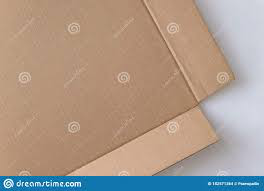

In [ ]:
cardboard = list(data_dir.glob('cardboard/*'))
PIL.Image.open(str(cardboard[0]))

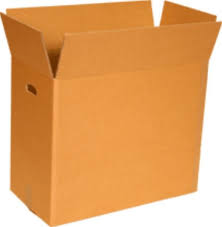

In [ ]:
PIL.Image.open(str(cardboard[1]))

Define some parameters for the data input:

In [ ]:
batch_size = 10
img_height = 100
img_width = 100

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names,num_classes)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass'] 12


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1242/1242 [==============================] - 23s 18ms/step - loss: 0.4455 - accuracy: 0.8480 - val_loss: 0.8009 - val_accuracy: 0.7879
Epoch 2/20
1242/1242 [==============================] - 23s 18ms/step - loss: 0.4384 - accuracy: 0.8497 - val_loss: 0.9034 - val_accuracy: 0.7709
Epoch 3/20
1242/1242 [==============================] - 23s 18ms/step - loss: 0.4164 - accuracy: 0.8575 - val_loss: 0.8380 - val_accuracy: 0.7757
Epoch 4/20
1242/1242 [==============================] - 23s 18ms/step - loss: 0.4209 - accuracy: 0.8563 - val_loss: 0.8858 - val_accuracy: 0.7654
Epoch 5/20
1242/1242 [==============================] - 23s 19ms/step - loss: 0.4184 - accuracy: 0.8573 - val_loss: 0.8884 - val_accuracy: 0.7657
Epoch 6/20
1242/1242 [==============================] - 23s 18ms/step - loss: 0.4130 - accuracy: 0.8625 - val_loss: 0.8805 - val_accuracy: 0.7883
Epoch 7/20
1242/1242 [==============================] - 23s 18ms/step - loss: 0.3976 - accuracy: 0.8655 - val_loss: 0.8538 -

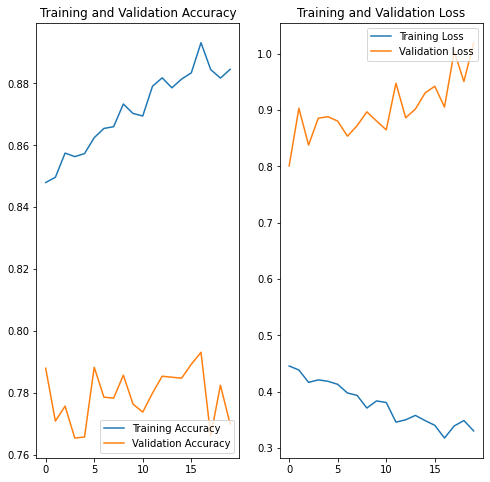

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


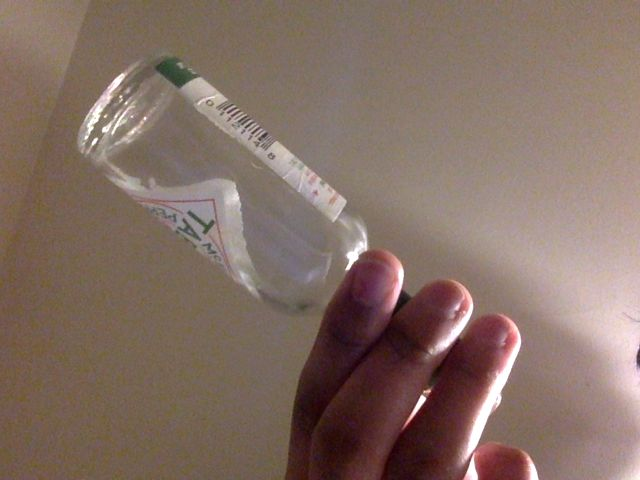

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:

photo_path = "/content/photo.jpg"
img = keras.preprocessing.image.load_img(
    photo_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to white-glass with a 48.60 percent confidence.


##Export Model &#8595;

In [ ]:
from google.colab import files
model.save_weights('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>